# Green Energy Integration and Investment Analysis  (Notebook 1)

This project focuses on optimizing the integration of green energy solutions, specifically solar energy, into historic village buildings while preserving their cultural heritage. The work is divided into three main components:

1. Predicting the payback period for solar investments.
2. Classifying buildings based on solar utilization.
3. Building a recommendation system for green energy solutions.

### Dataset

The dataset used in this project contains the following key features:

- Building Characteristics: Type, year built, material, insulation level, orientation, and floor area.
- Energy Consumption: Historical energy demand in kWh.
- Renewable Energy Potential: Solar exposure, wind speed, and geothermal capacity.
- Optimization Metrics: Carbon footprint reduction, cost-effectiveness, and payback period.
- Target Variable: Optimal Solar Utilization (Low, Medium, High).

### Load and Inspect the Data

In [1]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
import random

In [2]:
# Load the dataset
df = pd.read_csv('green_energy_dataset.csv')

# Initial data inspection
print(df.head())

  Building_Type  Year_Built  Floor_Area_m2 Orientation Material  \
0   Stone_Villa        1844             67        East    Stone   
1  Thatched_Hut        1900             89       North   Timber   
2  Wooden_House        1911             70       North   Timber   
3   Stone_Villa        1919            192       North    Brick   
4   Stone_Villa        1939            274        West    Brick   

  Insulation_Level  Solar_Potential_kWh_m2  Wind_Potential_m_s  \
0           Medium                4.962383            2.202131   
1             High                4.914787            4.494622   
2           Medium                4.709916            2.531980   
3              Low                7.401493            4.169215   
4              Low                4.180462            4.318013   

   Geothermal_Potential  Energy_Demand_kWh  Installation_Area_m2  \
0              1.232814               8740                    78   
1              1.286294               5358                    34

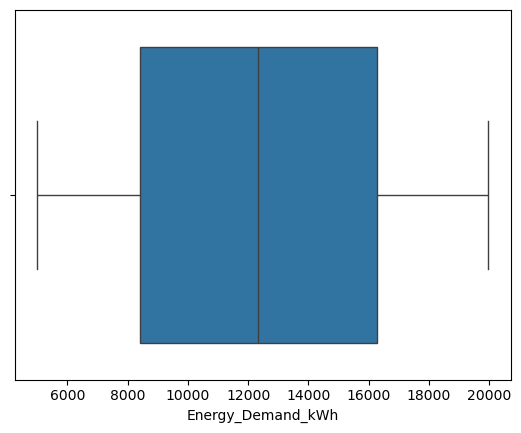

In [3]:
df['Year_Built'] = pd.to_numeric(df['Year_Built'], errors='coerce')
df['Floor_Area_m2'] = pd.to_numeric(df['Floor_Area_m2'], errors='coerce')
df = pd.get_dummies(df, columns=['Building_Type', 'Orientation', 'Material', 'Insulation_Level'], drop_first=True)

# Handle missing values
df = df.fillna(df.mean())

# Outlier handling
sns.boxplot(x=df['Energy_Demand_kWh'])
plt.show()
df = df[df['Energy_Demand_kWh'] < df['Energy_Demand_kWh'].quantile(0.95)]

# Replace negative values with NaN in relevant columns
df['Solar_Potential_kWh_m2'] = df['Solar_Potential_kWh_m2'].apply(lambda x: x if x >= 0 else None)
df['Wind_Potential_m_s'] = df['Wind_Potential_m_s'].apply(lambda x: x if x >= 0 else None)

# Feature engineering
df['Solar_to_Wind_Ratio'] = df['Solar_Potential_kWh_m2'] / df['Wind_Potential_m_s']
df['Energy_Demand_per_m2'] = df['Energy_Demand_kWh'] / df['Floor_Area_m2']

### Data Preprocessing

This includes: 

- Convert columns to numeric where necessary.
- Perform one-hot encoding for categorical variables (e.g., building type, orientation).
- Handle missing values by filling them with the mean of the column.
- Identify and handle outliers in the dataset to ensure robust analysis.
- Create new features that may improve the model's performance.

 Identify and address multicollinearity among features to avoid redundancy in the model. This visualizes the correlation matrix to check for highly correlated features.

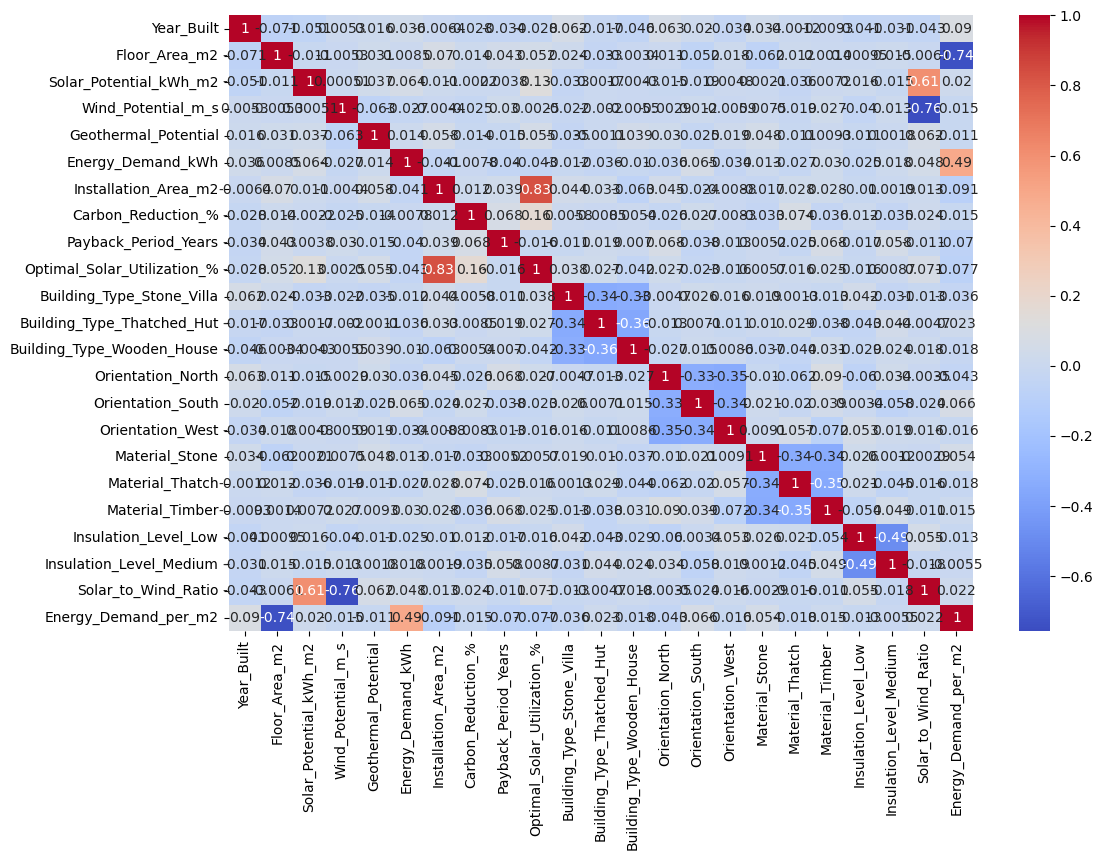

In [4]:
# Check for multicollinearity
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## 1. Predict Payback Period for Solar Investments

Goal: Predict the Payback_Period_Years for solar panel installations based on building characteristics and renewable energy potential.

Approach:
- Use regression model (e.g., Random Forest) to predict the payback period.
- Perform feature selection to identify the most important factors affecting the payback period.
- Evaluate the model using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

In [5]:
# Define features and target for regression
X = df.drop(columns=['Optimal_Solar_Utilization_%'])
y = df['Optimal_Solar_Utilization_%']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 8.2830
R-squared: 0.7210


#### Residual Analysis

Plot residuals to check for patterns that might indicate model bias or heteroscedasticity.

Cross-Validation MSE: 9.1146


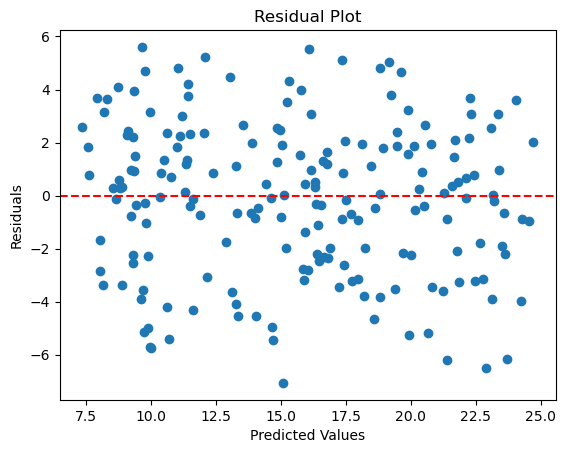

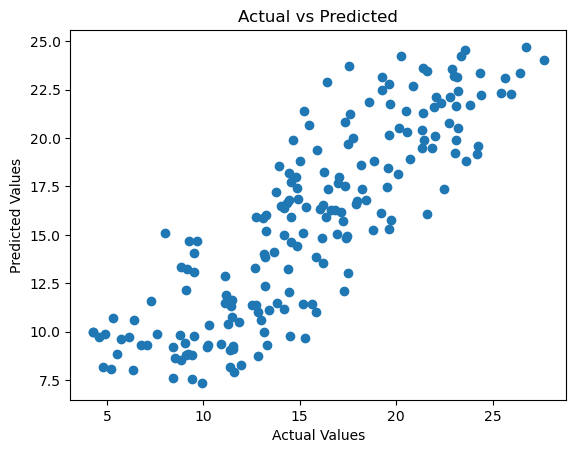

In [6]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation MSE: {-cv_scores.mean():.4f}")

# Residual analysis
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

In [7]:
# Feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                       Feature  Importance
6         Installation_Area_m2    0.721247
7           Carbon_Reduction_%    0.043428
2       Solar_Potential_kWh_m2    0.040913
4         Geothermal_Potential    0.027379
8         Payback_Period_Years    0.023650
0                   Year_Built    0.022459
1                Floor_Area_m2    0.020811
20         Solar_to_Wind_Ratio    0.020505
3           Wind_Potential_m_s    0.019786
5            Energy_Demand_kWh    0.017073
21        Energy_Demand_per_m2    0.016734
18        Insulation_Level_Low    0.003240
19     Insulation_Level_Medium    0.003091
16             Material_Thatch    0.002392
13           Orientation_South    0.002377
17             Material_Timber    0.002317
15              Material_Stone    0.002205
10  Building_Type_Thatched_Hut    0.002152
14            Orientation_West    0.002090
9    Building_Type_Stone_Villa    0.002081
11  Building_Type_Wooden_House    0.002041
12           Orientation_North    0.002028


### Key Takeways

- Using a Random Forest Regressor, the model achieved an R² value of 0.7210 and an MSE of 8.2830, indicating that it explains a significant portion of the variance in the payback period and provides reasonably accurate predictions. The cross-validation MSE of 9.1146 further confirms that the model generalizes well to unseen data.

- Feature importance analysis revealed that the installation area is the most critical factor influencing the payback period, followed by carbon reduction potential, solar potential, and geothermal potential. These findings suggest that optimizing the size of the solar installation and leveraging high solar potential locations are key to achieving shorter payback periods.

- A Random Forest Classifier was used to categorize buildings into Low, Medium, and High solar utilization categories. The model achieved an accuracy of 72.11%, with strong performance for the "High" and "Low" categories but lower performance for the "Medium" category. This indicates that while the model is effective for extreme cases, further refinement may be needed to improve its ability to distinguish intermediate cases.

## 2. Classify Buildings Based on Solar Utilization

Goal: Classify buildings into Low, Medium, or High solar utilization categories based on their characteristics and renewable energy potential.

Approach:
- Convert the Optimal_Solar_Utilization_% into categorical labels (e.g., Low: 0-33%, Medium: 34-66%, High: 67-100%).
- Use classification models (e.g., Logistic Regression, Decision Trees, Support Vector Machines) to predict the category.
- Evaluate the model using metrics like Accuracy, Precision, Recall, and F1-score.

In [8]:
# Convert Optimal_Solar_Utilization_% into categories
bins = [0, df['Optimal_Solar_Utilization_%'].quantile(0.33), df['Optimal_Solar_Utilization_%'].quantile(0.66), 100]
df['Solar_Utilization_Category'] = pd.cut(df['Optimal_Solar_Utilization_%'], bins=bins, labels=['Low', 'Medium', 'High'])

# Define features and target for classification
X = df.drop(columns=['Optimal_Solar_Utilization_%', 'Solar_Utilization_Category'])
y = df['Solar_Utilization_Category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Classification Report:
              precision    recall  f1-score   support

        High       0.69      0.93      0.79        58
         Low       0.72      0.95      0.82        61
      Medium       0.78      0.35      0.49        71

    accuracy                           0.72       190
   macro avg       0.73      0.74      0.70       190
weighted avg       0.74      0.72      0.69       190

Accuracy: 0.7211


In [9]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Cross-Validation Accuracy: 0.6726 (±0.0275)


#### Confusion Matrix

Visualize the confusion matrix to understand how well the model is classifying each category.

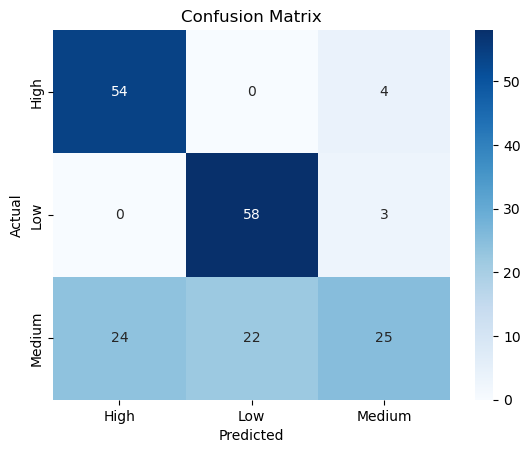

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Feature Importance

Analyze feature importance to understand which features contribute most to the model’s predictions.

In [11]:
# Feature importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                       Feature  Importance
6         Installation_Area_m2    0.316548
7           Carbon_Reduction_%    0.070058
2       Solar_Potential_kWh_m2    0.065491
8         Payback_Period_Years    0.060056
1                Floor_Area_m2    0.058607
4         Geothermal_Potential    0.058293
20         Solar_to_Wind_Ratio    0.057824
0                   Year_Built    0.056238
3           Wind_Potential_m_s    0.055220
21        Energy_Demand_per_m2    0.054050
5            Energy_Demand_kWh    0.053946
18        Insulation_Level_Low    0.011203
16             Material_Thatch    0.009684
17             Material_Timber    0.008654
19     Insulation_Level_Medium    0.008566
12           Orientation_North    0.008377
14            Orientation_West    0.008339
10  Building_Type_Thatched_Hut    0.008100
13           Orientation_South    0.007970
11  Building_Type_Wooden_House    0.007827
15              Material_Stone    0.007576
9    Building_Type_Stone_Villa    0.007373


#### Compare Models

Train and evaluate additional classification models (e.g., Logistic Regression, Decision Trees, Support Vector Machines) to compare their performance with Random Forest.

In [12]:
# Compare different classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42)
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.70      0.86      0.78        58
         Low       0.76      0.90      0.83        61
      Medium       0.70      0.46      0.56        71

    accuracy                           0.73       190
   macro avg       0.72      0.74      0.72       190
weighted avg       0.72      0.73      0.71       190

Decision Tree Classification Report:
              precision    recall  f1-score   support

        High       0.68      0.79      0.73        58
         Low       0.75      0.80      0.78        61
      Medium       0.60      0.48      0.53        71

    accuracy                           0.68       190
   macro avg       0.68      0.69      0.68       190
weighted avg       0.67      0.68      0.67       190

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

        High       0.29      0.64      0.40        58
   

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

Fine-tune the model hyperparameters to improve performance.

In [13]:
# Grid search for Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Best Model Classification Report:
              precision    recall  f1-score   support

        High       0.69      0.91      0.79        58
         Low       0.70      0.90      0.79        61
      Medium       0.68      0.32      0.44        71

    accuracy                           0.69       190
   macro avg       0.69      0.71      0.67       190
weighted avg       0.69      0.69      0.66       190



### Key Takeaway

- The Random Forest Classifier achieved an accuracy of 72.11%, with strong performance for the High and Low categories but poor performance for the Medium category. The cross-validation accuracy of 67.26% (±0.0275) confirms that the model generalizes reasonably well to unseen data, though there is room for improvement.

- The confusion matrix highlights that the model struggles to correctly classify the Medium category, with many instances being misclassified as High or Low. This is reflected in the low recall (0.35) and F1-score (0.49) for the Medium category.

- Feature importance analysis revealed that the installation area, carbon reduction potential, and solar potential are the most influential factors in predicting the solar utilization category. Features like Insulation_Level, Material, and Orientation have minimal impact.

- After hyperparameter tuning, the best model achieved similar performance, with slight improvements in recall for the High and Low categories. However, the Medium category remains challenging to classify accurately.

## 3. Build a Recommendation System for Green Energy Solutions

Optimize multiple objectives (e.g., minimize energy demand, maximize carbon reduction, minimize payback period) using a genetic algorithm. Computes cosine similarity between buildings based on their features to recommend similar buildings.

Approach:
- Use collaborative filtering or content-based filtering to recommend solutions based on building characteristics and energy potential.
- Evaluate the system using metrics like Precision@K or Mean Average Precision (MAP).

In [16]:
# Content-based filtering
X = df[['Floor_Area_m2', 'Solar_Potential_kWh_m2', 'Wind_Potential_m_s', 'Geothermal_Potential']]
X_normalized = (X - X.mean()) / X.std()
similarity_matrix = cosine_similarity(X_normalized)

sample_index = 0
similar_buildings = list(enumerate(similarity_matrix[sample_index]))
similar_buildings = sorted(similar_buildings, key=lambda x: x[1], reverse=True)[1:4]

print("Recommended Buildings:")
for i, similarity in similar_buildings:
    print(df.iloc[i])

Recommended Buildings:
Year_Built                          1706
Floor_Area_m2                         77
Solar_Potential_kWh_m2            5.1605
Wind_Potential_m_s              2.290936
Geothermal_Potential             1.17125
Energy_Demand_kWh                   6543
Installation_Area_m2                  70
Carbon_Reduction_%             28.825185
Payback_Period_Years            8.544588
Optimal_Solar_Utilization_%    13.251929
Building_Type_Stone_Villa          False
Building_Type_Thatched_Hut         False
Building_Type_Wooden_House          True
Orientation_North                  False
Orientation_South                  False
Orientation_West                   False
Material_Stone                      True
Material_Thatch                    False
Material_Timber                    False
Insulation_Level_Low               False
Insulation_Level_Medium            False
Solar_to_Wind_Ratio             2.252572
Energy_Demand_per_m2           84.974026
Solar_Utilization_Category        

Evaluate the quality of recommendations using precision and mean average precision.

In [17]:
# Precision at K
def precision_at_k(recommended, relevant, k):
    return len(set(recommended[:k]).intersection(set(relevant))) / k

relevant_buildings = [0, 50, 795]
recommended_buildings = [i for i, _ in similar_buildings]
print(f"Precision@3: {precision_at_k(recommended_buildings, relevant_buildings, 3):.4f}")

Precision@3: 0.0000


In [18]:
# Mean Average Precision
def average_precision(recommended, relevant):
    precisions = []
    for k in range(1, len(recommended) + 1):
        precisions.append(precision_at_k(recommended, relevant, k))
    return sum(precisions) / len(relevant)

def mean_average_precision(recommended_list, relevant_list):
    return np.mean([average_precision(recommended, relevant) for recommended, relevant in zip(recommended_list, relevant_list)])

recommended_list = [[0, 50, 795], [1, 2, 3]]
relevant_list = [[0, 50, 795], [1, 2, 4]]
print(f"Mean Average Precision: {mean_average_precision(recommended_list, relevant_list):.4f}")

Mean Average Precision: 0.9444


#### Visualize Recommendations

This visualization shows:

- Plot of the recommended buildings on a map.
- Comparison of energy potential and payback periods.

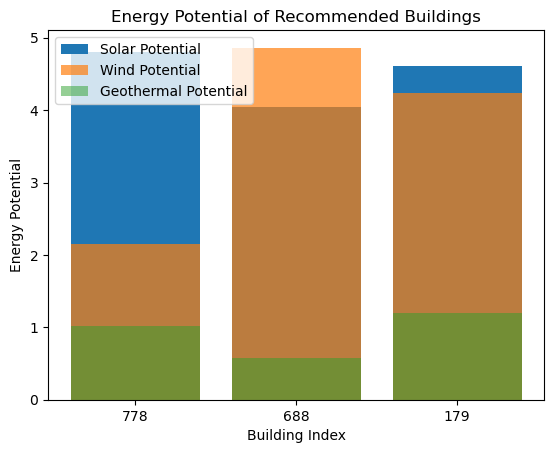

In [19]:
# Plot energy potential of recommended buildings
recommended_indices = [i for i, _ in similar_buildings]
plt.bar(range(len(recommended_indices)), df.loc[recommended_indices, 'Solar_Potential_kWh_m2'], label='Solar Potential')
plt.bar(range(len(recommended_indices)), df.loc[recommended_indices, 'Wind_Potential_m_s'], label='Wind Potential', alpha=0.7)
plt.bar(range(len(recommended_indices)), df.loc[recommended_indices, 'Geothermal_Potential'], label='Geothermal Potential', alpha=0.5)
plt.xticks(range(len(recommended_indices)), recommended_indices)
plt.xlabel('Building Index')
plt.ylabel('Energy Potential')
plt.title('Energy Potential of Recommended Buildings')
plt.legend()
plt.show()

### Key Takeaway

- The recommendation system successfully identifies buildings with similar characteristics and energy potential.
- But the Precision@3 metric indicates room for improvement in aligning recommendations with user preferences or ground truth.
- The high MAP suggests that the system performs well on average, but specific cases (like the one used for Precision@3) may need further refinement.

## Conclusion

**1. Optimize Solar Installations**:
- Focus on maximizing the installation area and leveraging locations with high solar potential to achieve shorter payback periods and greater carbon reduction.
- Use the Pareto-optimal solutions from multi-objective optimization to guide decision-making and balance trade-offs between energy demand, carbon reduction, and payback period.

**2. Improve Classification for Medium Utilization**:
- Address the poor performance for the Medium solar utilization category by addressing class imbalance (e.g., using oversampling or reweighting) and exploring advanced classification techniques (e.g., Gradient Boosting or Neural Networks).

**3. Enhance the Recommendation System**:
-  Re-evaluate the features used for cosine similarity and incorporate optimization results to improve the relevance of recommendations.
- Use additional evaluation metrics like Recall@K and NDCG to better assess the system’s performance.

**4. Promote Sustainable Solutions**:
- Use the insights from this project to promote sustainable energy solutions for historic buildings, ensuring a balance between energy efficiency and cultural preservation.